In [1]:
import os
import pandas as pd

In [9]:
folder_path = 'datamart/gold/feature_store/'

parquet_files = [f for f in os.listdir(folder_path) if f.endswith('.parquet')]

dfs = []
parquet_files = [f for f in parquet_files if len(os.path.splitext(f)[0].split('_')) == 3]
for file in parquet_files:
    file_path = os.path.join(folder_path, file)
    snapshot_date = os.path.splitext(file)[0]
    snapshot_date = snapshot_date.replace('_', '-')
    df = pd.read_parquet(file_path)
    df['snapshot_date'] = snapshot_date
    dfs.append(df)

total_df = pd.concat(dfs, ignore_index=True)

In [15]:
len(total_df)

39755

In [12]:
total_df.to_parquet('full_feature_table.parquet', index=False)

=== Method 1: Rolling Window Analysis (3-month window, monthly shift) ===
Total 15 months: ['2016-09', '2016-10', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12']

Starting rolling window calculation... ....................... Completed!

=== Method 2: Monthly vs Baseline Comparison ===
Baseline month: 2016-09, data count: 3
Starting monthly comparison calculation... . Completed!

=== Method 2: Monthly vs Baseline Comparison ===
Baseline month: 2016-09, data count: 3
Starting monthly comparison calculation... ........................... Completed!
 Completed!


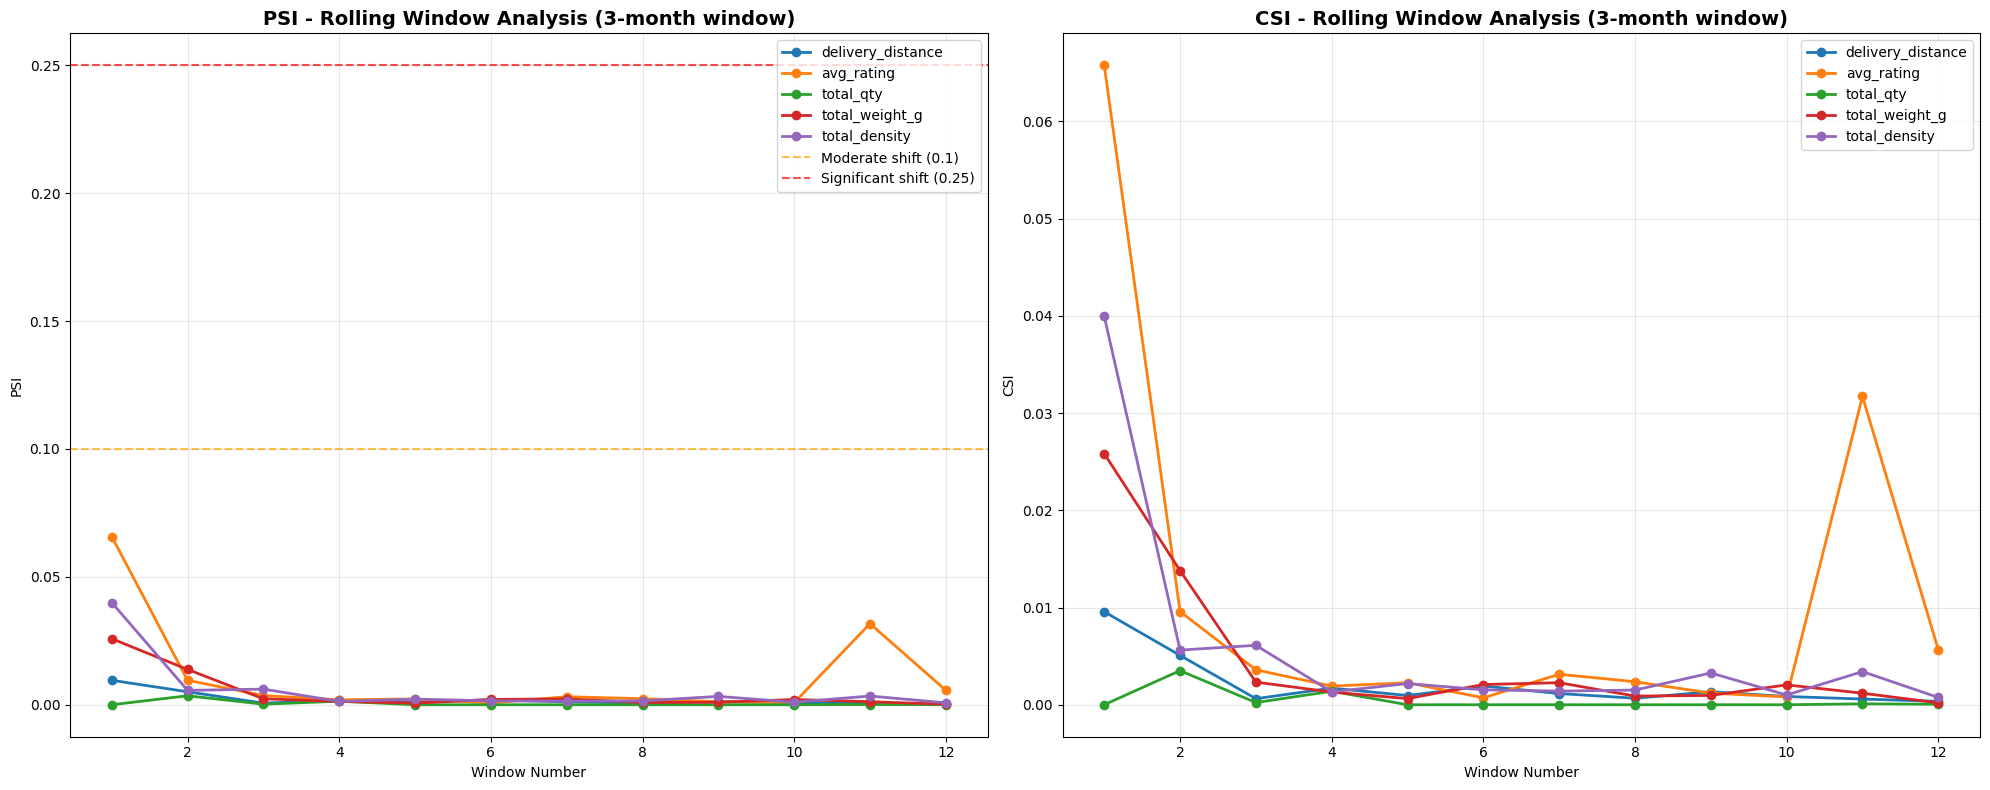

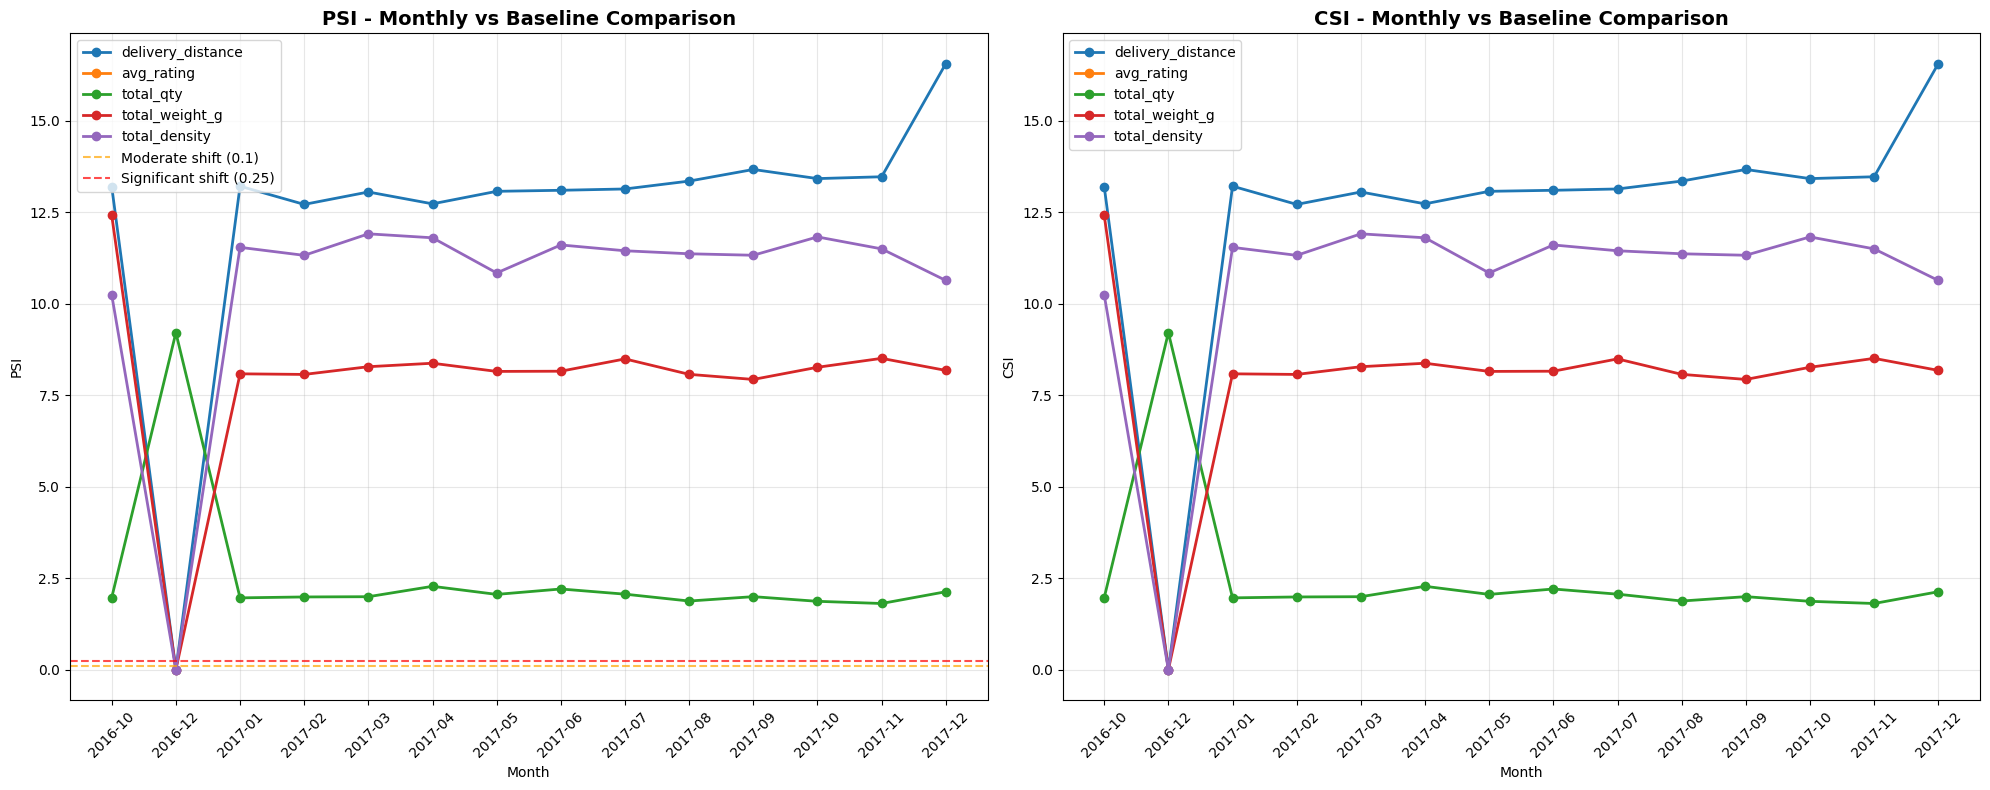


=== Analysis Results Summary ===
Rolling Window PSI Results:
             feature  window     window_label      base_period  \
0  delivery_distance       1  2016-10~2017-01  2016-09~2016-12   
1         avg_rating       1  2016-10~2017-01  2016-09~2016-12   
2          total_qty       1  2016-10~2017-01  2016-09~2016-12   
3     total_weight_g       1  2016-10~2017-01  2016-09~2016-12   
4      total_density       1  2016-10~2017-01  2016-09~2016-12   
5  delivery_distance       2  2016-12~2017-02  2016-10~2017-01   
6         avg_rating       2  2016-12~2017-02  2016-10~2017-01   
7          total_qty       2  2016-12~2017-02  2016-10~2017-01   
8     total_weight_g       2  2016-12~2017-02  2016-10~2017-01   
9      total_density       2  2016-12~2017-02  2016-10~2017-01   

    compare_period       psi  
0  2016-10~2017-01  0.009567  
1  2016-10~2017-01  0.065769  
2  2016-10~2017-01  0.000003  
3  2016-10~2017-01  0.025828  
4  2016-10~2017-01  0.039962  
5  2016-12~2017-02  0.005

In [29]:
import numpy as np

# Convert snapshot_date to datetime and add snapshot_month column
total_df['snapshot_month'] = pd.to_datetime(total_df['snapshot_date']).dt.to_period('M').astype(str)

# Fixed PSI calculation function
def calculate_psi_fixed(expected, actual, buckets=10):
    """Fixed version of PSI calculation function"""
    # Remove NaN values
    expected_clean = expected.dropna()
    actual_clean = actual.dropna()
    
    if len(expected_clean) == 0 or len(actual_clean) == 0:
        return np.nan
    
    # Calculate quantiles, avoid duplicate values issue
    try:
        bins = np.percentile(expected_clean, np.linspace(0, 100, buckets + 1))
        # Ensure bins are unique
        bins = np.unique(bins)
        if len(bins) < 2:
            return np.nan
            
        expected_counts = pd.cut(expected_clean, bins=bins, include_lowest=True, duplicates='drop').value_counts(normalize=True).sort_index()
        actual_counts = pd.cut(actual_clean, bins=bins, include_lowest=True, duplicates='drop').value_counts(normalize=True).sort_index()
        
        # Ensure both series have the same index
        all_bins = expected_counts.index.union(actual_counts.index)
        expected_counts = expected_counts.reindex(all_bins, fill_value=1e-6)
        actual_counts = actual_counts.reindex(all_bins, fill_value=1e-6)
        
        # Avoid division by zero
        expected_counts = expected_counts + 1e-6
        actual_counts = actual_counts + 1e-6
        
        psi = np.sum((actual_counts - expected_counts) * np.log(actual_counts / expected_counts))
        return psi
    except Exception as e:
        print(f"PSI calculation error: {e}")
        return np.nan

# Define CSI calculation function
def calculate_csi(expected, actual, buckets=10):
    expected_clean = expected.dropna()
    actual_clean = actual.dropna()
    if len(expected_clean) == 0 or len(actual_clean) == 0:
        return np.nan
    try:
        bins = np.percentile(expected_clean, np.linspace(0, 100, buckets + 1))
        bins = np.unique(bins)
        if len(bins) < 2:
            return np.nan
        expected_counts = pd.cut(expected_clean, bins=bins, include_lowest=True, duplicates='drop').value_counts(normalize=True).sort_index()
        actual_counts = pd.cut(actual_clean, bins=bins, include_lowest=True, duplicates='drop').value_counts(normalize=True).sort_index()
        all_bins = expected_counts.index.union(actual_counts.index)
        expected_counts = expected_counts.reindex(all_bins, fill_value=1e-6)
        actual_counts = actual_counts.reindex(all_bins, fill_value=1e-6)
        expected_counts = expected_counts + 1e-6
        actual_counts = actual_counts + 1e-6
        csi = np.sum((actual_counts - expected_counts) * np.log(actual_counts / expected_counts))
        return csi
    except Exception as e:
        print(f"CSI calculation error: {e}")
        return np.nan

# Rolling window analysis: moving one month at a time
def compute_rolling_psi_csi(df, feature_list, month_column, window_size=3):
    """
    Rolling window analysis, moving one month at a time
    window_size: window size (number of months)
    """
    months = sorted(df[month_column].unique())
    print(f"Total {len(months)} months: {months}")
    
    if len(months) < window_size + 1:
        print(f"Warning: Need at least {window_size + 1} months for rolling window analysis")
        return pd.DataFrame(), pd.DataFrame()
    
    psi_records = []
    csi_records = []
    
    # Rolling window: move one month at a time
    print(f"\nStarting rolling window calculation... ", end="")
    for i in range(len(months) - window_size):
        print(".", end="", flush=True)  # Print a dot for each window
        
        # Base window: first window_size months
        base_months = months[i:i + window_size]
        # Compare window: next window_size months
        compare_months = months[i + 1:i + 1 + window_size]
        
        # Combine base period data
        base_df = df[df[month_column].isin(base_months)]
        # Combine compare period data
        compare_df = df[df[month_column].isin(compare_months)]
        
        # Calculate PSI and CSI for each feature
        for f in feature_list:
            if f in df.columns:
                psi_value = calculate_psi_fixed(base_df[f], compare_df[f])
                csi_value = calculate_csi(base_df[f], compare_df[f])
                
                # Record results
                window_label = f"{compare_months[0]}~{compare_months[-1]}"
                psi_records.append({
                    "feature": f, 
                    "window": i+1,
                    "window_label": window_label,
                    "base_period": f"{base_months[0]}~{base_months[-1]}",
                    "compare_period": f"{compare_months[0]}~{compare_months[-1]}",
                    "psi": psi_value
                })
                csi_records.append({
                    "feature": f, 
                    "window": i+1,
                    "window_label": window_label,
                    "base_period": f"{base_months[0]}~{base_months[-1]}",
                    "compare_period": f"{compare_months[0]}~{compare_months[-1]}",
                    "csi": csi_value
                })
    
    print(" Completed!")  # New line and show completion
    psi_df = pd.DataFrame(psi_records)
    csi_df = pd.DataFrame(csi_records)
    return psi_df, csi_df

# Monthly comparison analysis: compare each month with baseline month
def compute_monthly_vs_baseline(df, feature_list, month_column):
    """
    Compare each month with the first month (baseline month)
    """
    months = sorted(df[month_column].unique())
    if len(months) < 2:
        print("Warning: Need at least 2 months for comparison")
        return pd.DataFrame(), pd.DataFrame()
    
    base_month = months[0]
    base_df = df[df[month_column] == base_month]
    
    psi_records = []
    csi_records = []
    
    print(f"Baseline month: {base_month}, data count: {len(base_df)}")
    print(f"Starting monthly comparison calculation... ", end="")
    
    for month in months[1:]:
        print(".", end="", flush=True)  # Print a dot for each month
        current_df = df[df[month_column] == month]
        
        for f in feature_list:
            if f in df.columns:
                psi_value = calculate_psi_fixed(base_df[f], current_df[f])
                csi_value = calculate_csi(base_df[f], current_df[f])
                
                psi_records.append({
                    "feature": f, 
                    "month": month,
                    "psi": psi_value
                })
                csi_records.append({
                    "feature": f, 
                    "month": month,
                    "csi": csi_value
                })
    
    print(" Completed!")  # New line and show completion
    psi_df = pd.DataFrame(psi_records)
    csi_df = pd.DataFrame(csi_records)
    return psi_df, csi_df

# Execute analysis
feature_list = ['delivery_distance', 'avg_rating', 'total_qty', 'total_weight_g', 'total_density']

print("=== Method 1: Rolling Window Analysis (3-month window, monthly shift) ===")
rolling_psi_df, rolling_csi_df = compute_rolling_psi_csi(total_df, feature_list, 'snapshot_month', window_size=3)

print("\n=== Method 2: Monthly vs Baseline Comparison ===")
monthly_psi_df, monthly_csi_df = compute_monthly_vs_baseline(total_df, feature_list, 'snapshot_month')

# Plotting
import matplotlib.pyplot as plt

# Rolling window results charts
if not rolling_psi_df.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # PSI rolling window
    for feature in feature_list:
        sub = rolling_psi_df[rolling_psi_df['feature'] == feature]
        ax1.plot(sub['window'], sub['psi'], marker='o', label=f'{feature}', linewidth=2)
    ax1.axhline(0.1, color='orange', linestyle='--', label='Moderate shift (0.1)', alpha=0.7)
    ax1.axhline(0.25, color='red', linestyle='--', label='Significant shift (0.25)', alpha=0.7)
    ax1.set_title('PSI - Rolling Window Analysis (3-month window)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Window Number')
    ax1.set_ylabel('PSI')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # CSI rolling window
    for feature in feature_list:
        sub = rolling_csi_df[rolling_csi_df['feature'] == feature]
        ax2.plot(sub['window'], sub['csi'], marker='o', label=f'{feature}', linewidth=2)
    ax2.set_title('CSI - Rolling Window Analysis (3-month window)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Window Number')
    ax2.set_ylabel('CSI')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Monthly comparison results charts
if not monthly_psi_df.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # PSI monthly comparison
    for feature in feature_list:
        sub = monthly_psi_df[monthly_psi_df['feature'] == feature]
        ax1.plot(sub['month'], sub['psi'], marker='o', label=f'{feature}', linewidth=2)
    ax1.axhline(0.1, color='orange', linestyle='--', label='Moderate shift (0.1)', alpha=0.7)
    ax1.axhline(0.25, color='red', linestyle='--', label='Significant shift (0.25)', alpha=0.7)
    ax1.set_title('PSI - Monthly vs Baseline Comparison', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('PSI')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # CSI monthly comparison
    for feature in feature_list:
        sub = monthly_csi_df[monthly_csi_df['feature'] == feature]
        ax2.plot(sub['month'], sub['csi'], marker='o', label=f'{feature}', linewidth=2)
    ax2.set_title('CSI - Monthly vs Baseline Comparison', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('CSI')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

print("\n=== Analysis Results Summary ===")
if not rolling_psi_df.empty:
    print("Rolling Window PSI Results:")
    print(rolling_psi_df.head(10))

if not monthly_psi_df.empty:
    print("\nMonthly Comparison PSI Results:")
    print(monthly_psi_df.head(10))

In [30]:
print("Min snapshot_date:", total_df['snapshot_date'].min())
print("Max snapshot_date:", total_df['snapshot_date'].max())

Min snapshot_date: 2016-09-04
Max snapshot_date: 2017-12-02


In [32]:
# Get sorted unique months from total_df
all_months = sorted(total_df['snapshot_month'].unique())

# Select last 15 months: 12 for training, 3 for OOT (one month each)
train_months = all_months[-15:-3]
oot1_month = all_months[-3]
oot2_month = all_months[-2]
oot3_month = all_months[-1]

# Split data
train_df = total_df[total_df['snapshot_month'].isin(train_months)].copy()
oot1_df = total_df[total_df['snapshot_month'] == oot1_month].copy()
oot2_df = total_df[total_df['snapshot_month'] == oot2_month].copy()
oot3_df = total_df[total_df['snapshot_month'] == oot3_month].copy()

print("Train months:", train_months)
print("OOT1 month:", oot1_month)
print("OOT2 month:", oot2_month)
print("OOT3 month:", oot3_month)
print("Train shape:", train_df.shape)
print("OOT1 shape:", oot1_df.shape)
print("OOT2 shape:", oot2_df.shape)
print("OOT3 shape:", oot3_df.shape)

Train months: ['2016-09', '2016-10', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09']
OOT1 month: 2017-10
OOT2 month: 2017-11
OOT3 month: 2017-12
Train shape: (27248, 23)
OOT1 shape: (4568, 23)
OOT2 shape: (7451, 23)
OOT3 shape: (488, 23)


              feature oot_set       psi       csi
0   delivery_distance    OOT1  0.002534  0.002534
1          avg_rating    OOT1  0.001962  0.001962
2           total_qty    OOT1  0.000000  0.000000
3      total_weight_g    OOT1  0.007581  0.007581
4       total_density    OOT1  0.007482  0.007482
5   delivery_distance    OOT2  0.004022  0.004022
6          avg_rating    OOT2  0.072092  0.072092
7           total_qty    OOT2  0.000000  0.000000
8      total_weight_g    OOT2  0.010037  0.010037
9       total_density    OOT2  0.016007  0.016007
10  delivery_distance    OOT3  0.034717  0.034717
11         avg_rating    OOT3  0.102473  0.102473
12          total_qty    OOT3  0.000000  0.000000
13     total_weight_g    OOT3  0.048617  0.048617
14      total_density    OOT3  0.035011  0.035011


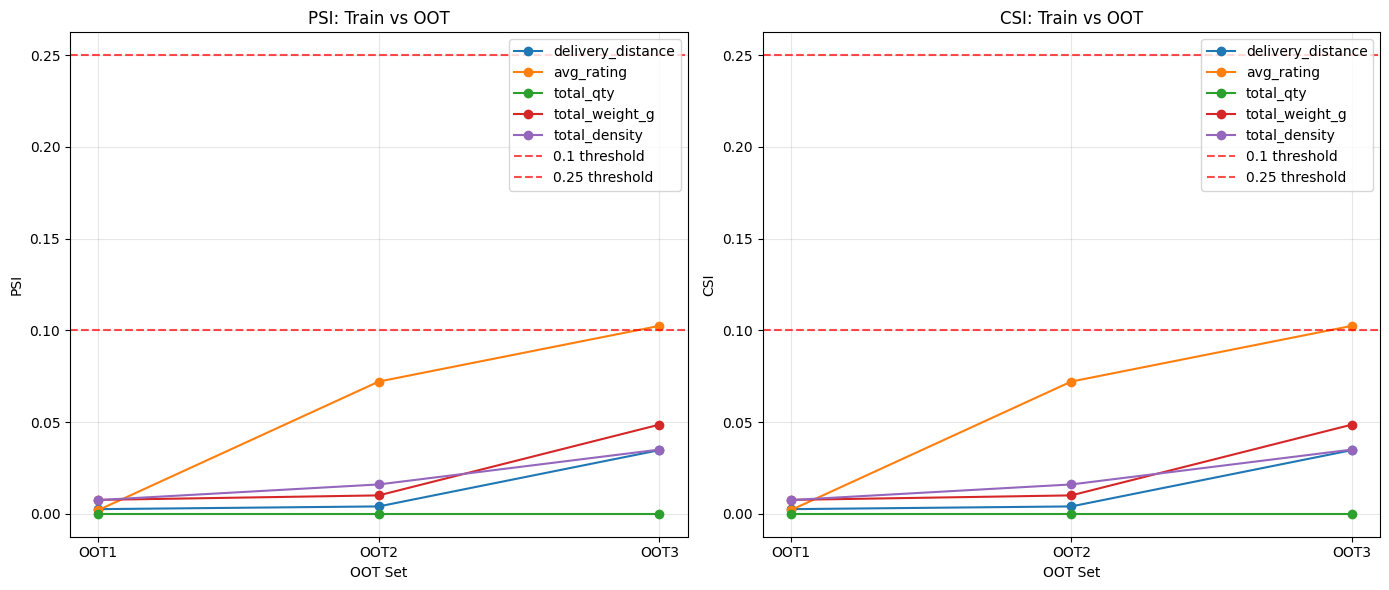

In [37]:
# Calculate PSI and CSI between train and each OOT set for required_features
results = []

for oot_name, oot_df in zip(['OOT1', 'OOT2', 'OOT3'], [oot1_df, oot2_df, oot3_df]):
    for feature in required_features:
        if feature in train_df.columns and feature in oot_df.columns:
            psi = calculate_psi_fixed(train_df[feature], oot_df[feature])
            csi = calculate_csi(train_df[feature], oot_df[feature])
            results.append({
                'feature': feature,
                'oot_set': oot_name,
                'psi': psi,
                'csi': csi
            })

psi_csi_df = pd.DataFrame(results)
print(psi_csi_df)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PSI plot
for feature in required_features:
    sub = psi_csi_df[psi_csi_df['feature'] == feature]
    axes[0].plot(sub['oot_set'], sub['psi'], marker='o', label=feature)
axes[0].axhline(0.1, color='red', linestyle='--', alpha=0.7, label='0.1 threshold')
axes[0].axhline(0.25, color='red', linestyle='--', alpha=0.7, label='0.25 threshold')
axes[0].set_title('PSI: Train vs OOT')
axes[0].set_xlabel('OOT Set')
axes[0].set_ylabel('PSI')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CSI plot
for feature in required_features:
    sub = psi_csi_df[psi_csi_df['feature'] == feature]
    axes[1].plot(sub['oot_set'], sub['csi'], marker='o', label=feature)
axes[1].axhline(0.1, color='red', linestyle='--', alpha=0.7, label='0.1 threshold')
axes[1].axhline(0.25, color='red', linestyle='--', alpha=0.7, label='0.25 threshold')
axes[1].set_title('CSI: Train vs OOT')
axes[1].set_xlabel('OOT Set')
axes[1].set_ylabel('CSI')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
